In [2]:
import importlib
import os
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import prettypyplot as pplt
import pyemma
import scipy
import seaborn as sns
from matplotlib import ticker
from sklearn import metrics

import extq

import mdtraj as md
import MDAnalysis as mda

/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


In [3]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import plotting
import util

In [4]:
pplt.load_cmaps()
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)

In [5]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

# Load data

In [6]:
DATA_DIR = "/project/dinner/scguo/ci-vsd/data"
# S4 translocation/rotation data
cv_trajs = list(
    np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton2.npy"))
cv_arr = np.concatenate(cv_trajs)
# salt bridge distances for states
sb_trajs = list(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton2.npy"))
sb_arr = np.concatenate(sb_trajs)
sb_models = np.load(f"{DATA_DIR}/models_centroids_feat2.npy")
# committors
lag = 500
qp_du = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[
    8
]  # 50 ns lag time
# weights
weights = np.load(
    f"{DATA_DIR}/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True
)[
    0
]  # 0.1 ns lag time

In [7]:
# states to do stopping
end = 4150115
dist = cv_arr[:end, 0]
rot = cv_arr[:end, 1]
sb1 = sb_arr[:end, 42]  # R226-D129
sb2 = sb_arr[:end, 47]  # R226-D186
sb3 = sb_arr[:end, 48]  # R229-D129
sb4 = sb_arr[:end, 53]  # R229-D186
sb5 = sb_arr[:end, 59]  # R232-D186

# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = np.nonzero(
    ((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)
)[0]

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up_ids = np.nonzero(
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    & (sb5 < 0.6)
)[0]

In [8]:
def bin_inds(q, qstep=0.05, low=0, hi=1):
    q_arr = np.concatenate(q)
    nsteps = round((hi - low) / qstep)
    all_inds = []
    steps = np.linspace(low, hi - qstep, nsteps)
    for i, s in enumerate(steps):
        q_inds = ((q_arr >= s) & (q_arr <= s + qstep)).nonzero()[0]
        all_inds.append(q_inds)
    return steps, all_inds

In [9]:
# sample structures to run PMEPOT calculations
N = 1000
np.random.seed(123)
_, [tse_ids] = bin_inds(qp_du, qstep=0.1, low=0.45, hi=0.55)

down_pme_ids = np.random.choice(down_ids, size=N, replace=False)
up_pme_ids = np.random.choice(up_ids, size=N, replace=False)
tse_pme_ids = np.random.choice(tse_ids, size=N, replace=False)

In [10]:
remove = {
    1282,
    1283,
    1284,
    1285,
    1286,
    1288,
    1289,
    1290,
    1187,
    1188,
    1189,
    1190,
    1191,
    1197,
    1198,
    1199,
    1203,
    1205,
    1206,
    1207,
    1211,
    1212,
    1213,
    1214,
    1215,
    1225,
    1226,
    1227,
    1228,
    1231,
    1232,
    1233,
    1236,
    1237,
    1238,
    1242,
    1245,
    1246,
    1252,
    1253,
    1260,
    1261,
    1262,
    1263,
    1266,
    1267,
    1268,
    1269,
    1270,
    1271,
    1272,
    1273,
    1274,
    1275,
    1276,
    1277,
    1278,
    1279,
}
files = []
for i in range(295):
    if (i + 1000) not in remove:
        files.append(f"/project/dinner/scguo/anton-old/civsd_{i}.dcd")
anton_files = []
for i in range(3, 119):
    if i == 82:
        pass
    anton_files.append(f"/beagle3/dinner/scguo/anton2-backup/dcdfiles/civsd.{i}.dcd")

In [11]:
topfile = "/project/dinner/scguo/ci-vsd/civsd-all.prmtop"


def write_id_txt(ids, files, anton_files, outfile):
    with open(outfile, mode="w+") as f:
        for close_id in ids:
            if close_id < 3_000_000:
                traj, frame = util.anton_frame(close_id)
                f.write(f"/project/dinner/scguo/anton-old/civsd_{traj}.dcd\t{frame}\n")
            else:
                traj, frame = (
                    (close_id - 3_000_000) // 10001,
                    (close_id - 3_000_000) % 10001,
                )
                f.write(f"{anton_files[traj]}\t{frame}\n")

In [32]:
write_id_txt(down_pme_ids, files, anton_files, "../../pmepot/down_pme_frames.txt")

In [33]:
write_id_txt(up_pme_ids, files, anton_files, "../../pmepot/up_pme_frames.txt")

In [34]:
write_id_txt(tse_pme_ids, files, anton_files, "../../pmepot/tse_pme_frames.txt")

## save frames together

In [42]:
with open("../../pmepot/down_pme_frames.txt", mode="r") as f:
    line = next(f)
    name, ix = line.strip("\n").split()
    ix = int(ix)

In [44]:
test_frame = md.load_frame(name, ix, top=topfile)

In [46]:
top = md.load_topology(topfile)

In [47]:
traj = md.Trajectory(
    test_frame.xyz,
    top,
    unitcell_angles=test_frame.unitcell_angles,
    unitcell_lengths=test_frame.unitcell_lengths,
)

In [49]:
traj.save("/tmp/test.dcd")

**NOTE:** S1-S3 of structures aligned to up state

## Run PMEPOT calculations

## Analyze PMEPOT results

In [12]:
sys.path.insert(1, "../../pmepot/")

In [13]:
import vgrid

In [14]:
# for each x/y slice, run the script
import math
def compute_z_profile(xc, yc, vdata):
    nx, ny, nz = vdata.dims
    hx, hy, hz = vdata.spac
    xmin, ymin, zmin = vdata.origin
    zlen = float(nz - 1) * hz
    zmax = zmin + zlen
    
    zini = int(math.ceil(zmin))
    zend = int(math.ceil(zmax)) - 1
    dz = 0.5
    nz = int((zend - zini) / dz) + 1

    result = np.zeros((nz, 2))
    for iz in range(0, nz):
        z = iz * dz + zini
        value = vdata.value((xc, yc, z))
        result[iz, 0] = z
        result[iz, 1] = value
    return result


In [15]:
def load_vdata(filename):
    dims = (None, None, None)
    file = open(filename)
    origin = (None, None, None)
    spac = (None, None, None)
    n = None
    data = []
    vdata = vgrid.Vgrid(dims, spac, origin, data)
    vdata.readOpenDX(file)
    return vdata

## Analyze structure files

In [72]:
down_frames = md.load("../../pmepot/down_pme_frames_wrap.dcd", top="../../models/MD-clustering-center/civsd.psf")

In [53]:
for i in range(3):
    print(down_frames.xyz[:, :, i].min(), down_frames.xyz[:, :, i].max())

-6.983177 7.165445
-7.089724 7.052875
-4.686886 4.6482973


In [54]:
prot_indices = down_frames.top.select("protein")
prot_xyz = down_frames.atom_slice(prot_indices).xyz
print(prot_xyz[:, :, 0].min(), prot_xyz[:, :, 1].min())
# print(np.min(prot_xyz[0], axis=0), np.max(prot_xyz[0], axis=0))
# down_frames.superpose(down_frames)
# print(prot_xyz[:, :, 0].max(), prot_xyz[:, :, 0].min())

-2.9978745 -3.032254


In [75]:
# x/y coords of hydrophobic plug - F161, I126, I190
plug_indices = down_frames.top.select("protein and resid 20 55 84")
plug_xyz = down_frames.atom_slice(plug_indices).xyz
print(plug_xyz.mean((0, 1)))
print(plug_xyz.mean(1).min(axis=0) * 10, plug_xyz.mean(1).max(axis=0) * 10)
# for i in range(1000):
#     print(plug_xyz[i] * 10)

[-0.07637381  0.0815071  -0.24444148]
[-3.067632  -1.7683012 -4.3199253] [ 1.247005   2.6467311 -1.4180564]


In [161]:
table, bonds = down_frames.top.to_dataframe()

In [169]:
down_frames.top.select("protein and resid 118")

array([1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904,
       1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912])

In [173]:
# x/y coords of arginines
down_zlocs = []
for i in (217, 223, 226, 229, 232):
    r226_indices = down_frames.top.select(f"protein and resid {i - 106} and name CZ")
    r226_xyz = down_frames.atom_slice(r226_indices).xyz
    print(i)
    print(r226_xyz.mean((0, 1)) * 10, r226_xyz.std((0, 1)) * 10)
    print(r226_xyz.min((0, 1)) * 10, r226_xyz.mean((0, 1)) * 10)
    down_zlocs.append(r226_xyz.mean((0, 1))[2] * 10)

217
[10.317851  -5.7780104 13.730934 ] [4.259403  6.0884714 1.516446 ]
[-20.008179  -17.169283    7.1845484] [10.317851  -5.7780104 13.730934 ]
223
[2.926517   0.17015877 5.1398573 ] [1.2663924 1.7285717 1.0537277]
[-5.6268     -5.9462304  -0.23057365] [2.926517   0.17015877 5.1398573 ]
226
[ 1.527802  -1.1098256 -4.6227603] [1.242256  1.6456473 1.6436361]
[-4.615207  -7.7183657 -9.146218 ] [ 1.527802  -1.1098256 -4.6227603]
229
[  6.781584  -3.991803 -11.822355] [3.029993  3.757687  1.4796085]
[-10.299868 -13.779391 -16.241728] [  6.781584  -3.991803 -11.822355]
232
[ 12.964628  -2.770948 -14.383315] [3.4448729 6.994987  1.8935611]
[-15.932964 -17.559982 -19.176119] [ 12.964628  -2.770948 -14.383315]


In [129]:
# z coords of lipids?
lipid_indices = down_frames.top.select("resname POPC and element P")
lipid_xyz = down_frames.atom_slice(lipid_indices).xyz
print(lipid_xyz.min(0)[:, 2] * 10, lipid_xyz.max(0)[:, 2] * 10)
print(lipid_xyz.min((0, 1)) * 10, lipid_xyz.max((0, 1)) * 10)

[  8.264426    9.000698    7.5262814   7.3842196   8.688383    9.504347
   8.96732     7.5673866   9.420446    8.148539   10.325409    8.862741
   7.158757   10.050156    9.9267845   9.201683    8.379377   10.52651
  10.121459    8.452719    9.225407    9.389631    9.163364    9.298557
 -29.286327  -29.088032  -28.86274   -29.091827  -28.131042  -29.114912
 -30.279692  -28.390066  -28.397675  -29.14544   -29.531181  -32.331554
 -28.570938  -28.209093  -30.457596  -27.546312  -28.746574  -30.10987
 -27.826689  -28.424814  -28.502003  -28.629816  -28.396255    8.013523
   9.658075    9.37909    10.132528    9.889769    7.263803    9.441819
  10.2927      8.835636    8.834021    9.0173645   8.971455   10.051805
  10.042585    6.5676775   8.314877    9.581653    9.613613    6.6882896
   9.218174    7.720284  -28.847124  -29.209656  -29.79203   -29.87933
 -28.88469   -27.989056  -27.888983  -28.00884   -29.058361  -27.839958
 -30.427664  -29.380043  -30.433891  -28.335884  -30.91522   -27.9

In [343]:
nx, ny, nz = vdata.dims
hx, hy, hz = vdata.spac
xmin, ymin, zmin = vdata.origin
xlen = float(nx - 1) * hx
ylen = float(ny - 1) * hy
zlen = float(nz - 1) * hz
xmax = xmin + xlen
ymax = ymin + ylen
zmax = zmin + zlen
xcent = xmin + 0.5 * xlen
ycent = ymin + 0.5 * ylen
zcent = zmin + 0.5 * zlen

In [344]:
print(nx, ny, nz)
print(hx, hy, hz)
print(xmin, ymin, zmin)
print(xmax, ymax, zmax)
print(xcent, ycent, zcent)

160 160 176
0.492565 0.492565 0.494054
-110.878 -66.5369 -74.2236
-32.560165 11.780935 12.23585
-71.7190825 -27.3779825 -30.993875000000003


## z-profile

In [31]:
# down
# down_pot = np.loadtxt("../../pmepot/down_pme_frames_aligned-xyz.txt")
# down_pot = np.loadtxt("../../pmepot/down_pme_frames-xyz.txt")
vdata = load_vdata("../../pmepot/dx/down_pme_frames_wrap.dx")

Text(0, 0.5, 'Potential / V')

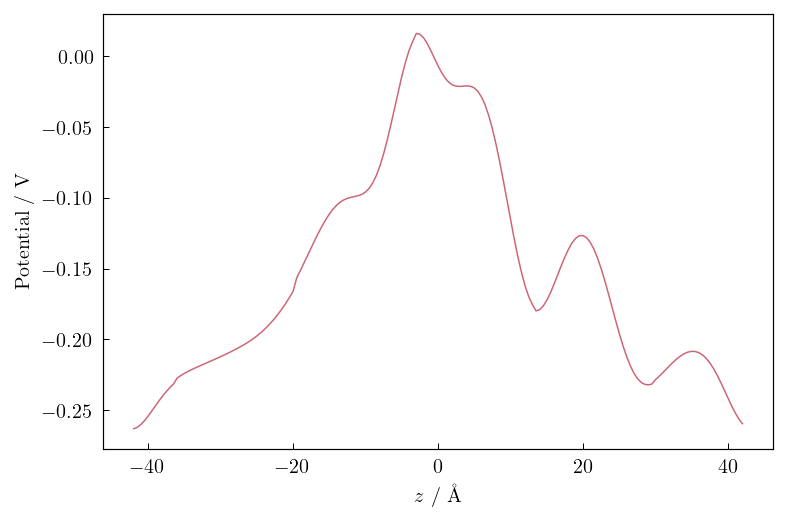

In [100]:
avg = np.zeros((169, 2))
for xc in np.linspace(-2, 2, 6):
    for yc in np.linspace(-2, 2, 6):
        z_profile = compute_z_profile(xc, yc, vdata)
        avg += z_profile / 36
plt.plot(avg[:,0], avg[:, 1] * 0.596 / 23.03)
plt.xlabel(r"$z$ / $\textrm{\AA}$")
plt.ylabel("Potential / V")
# for xc in np.linspace(-5, 5, 11):
#     z_profile = compute_z_profile(xc, 0, vdata)
#     plt.plot(z_profile[:,0], z_profile[:, 1])
# for yc in np.linspace(-5, 5, 11):
#     z_profile = compute_z_profile(0, yc, vdata)
#     plt.plot(z_profile[:,0], z_profile[:, 1])

In [43]:
vdata_up = load_vdata("../../pmepot/dx/up_pme_frames_wrap.dx")

Text(0, 0.5, 'Potential / V')

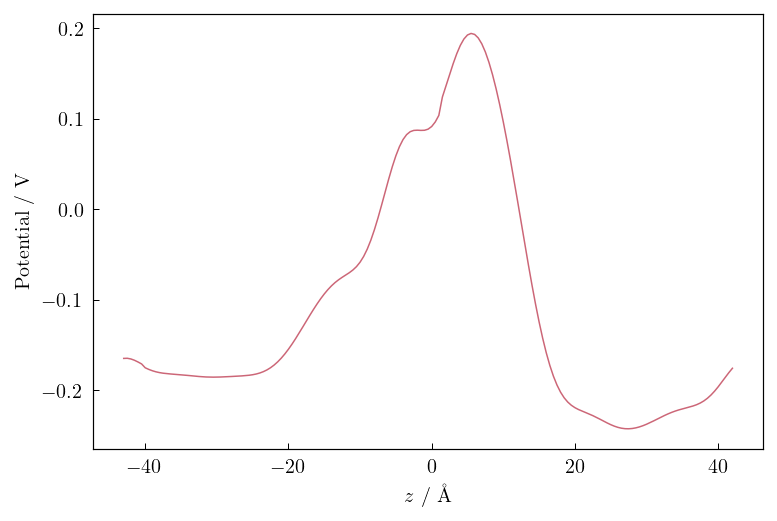

In [97]:
avg_up = np.zeros((171, 2))
for xc in np.linspace(-2, 2, 6):
    for yc in np.linspace(-2, 2, 6):
        z_profile = compute_z_profile(xc, yc, vdata_up)
        avg_up += z_profile / 36
plt.plot(avg_up[:,0], avg_up[:, 1] * 0.596 / 23.03)
plt.xlabel(r"$z$ / $\textrm{\AA}$")
plt.ylabel("Potential / V")

In [50]:
vdata_tse = load_vdata("../../pmepot/dx/tse_pme_frames_wrap.dx")

Text(0, 0.5, 'Potential / V')

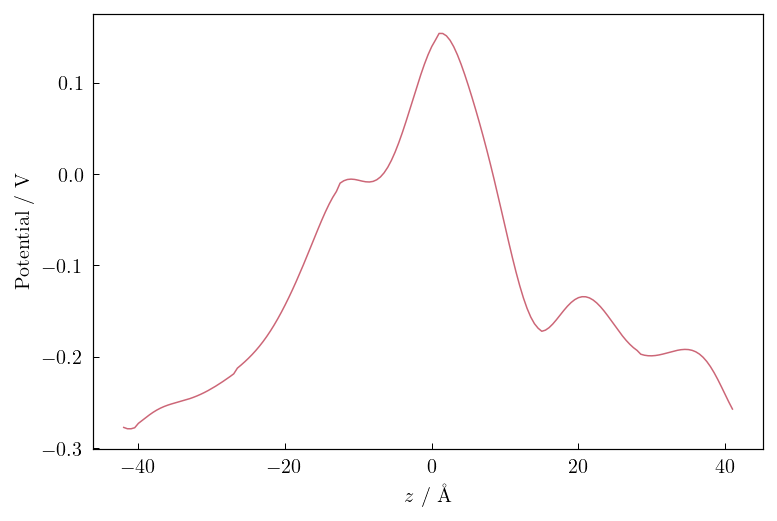

In [142]:
avg_tse = np.zeros((167, 2))
for xc in np.linspace(-2, 2, 6):
    for yc in np.linspace(-2, 2, 6):
        z_profile = compute_z_profile(xc, yc, vdata_tse)
        avg_tse += z_profile / 36
plt.plot(avg_tse[:,0], avg_tse[:, 1] * 0.596 / 23.03)
# plt.plot(avg_tse[:,0], np.cumsum(avg_tse[:, 1]) / np.sum(avg_tse[:, 1]))
plt.xlabel(r"$z$ / $\textrm{\AA}$")
plt.ylabel("Potential / V")

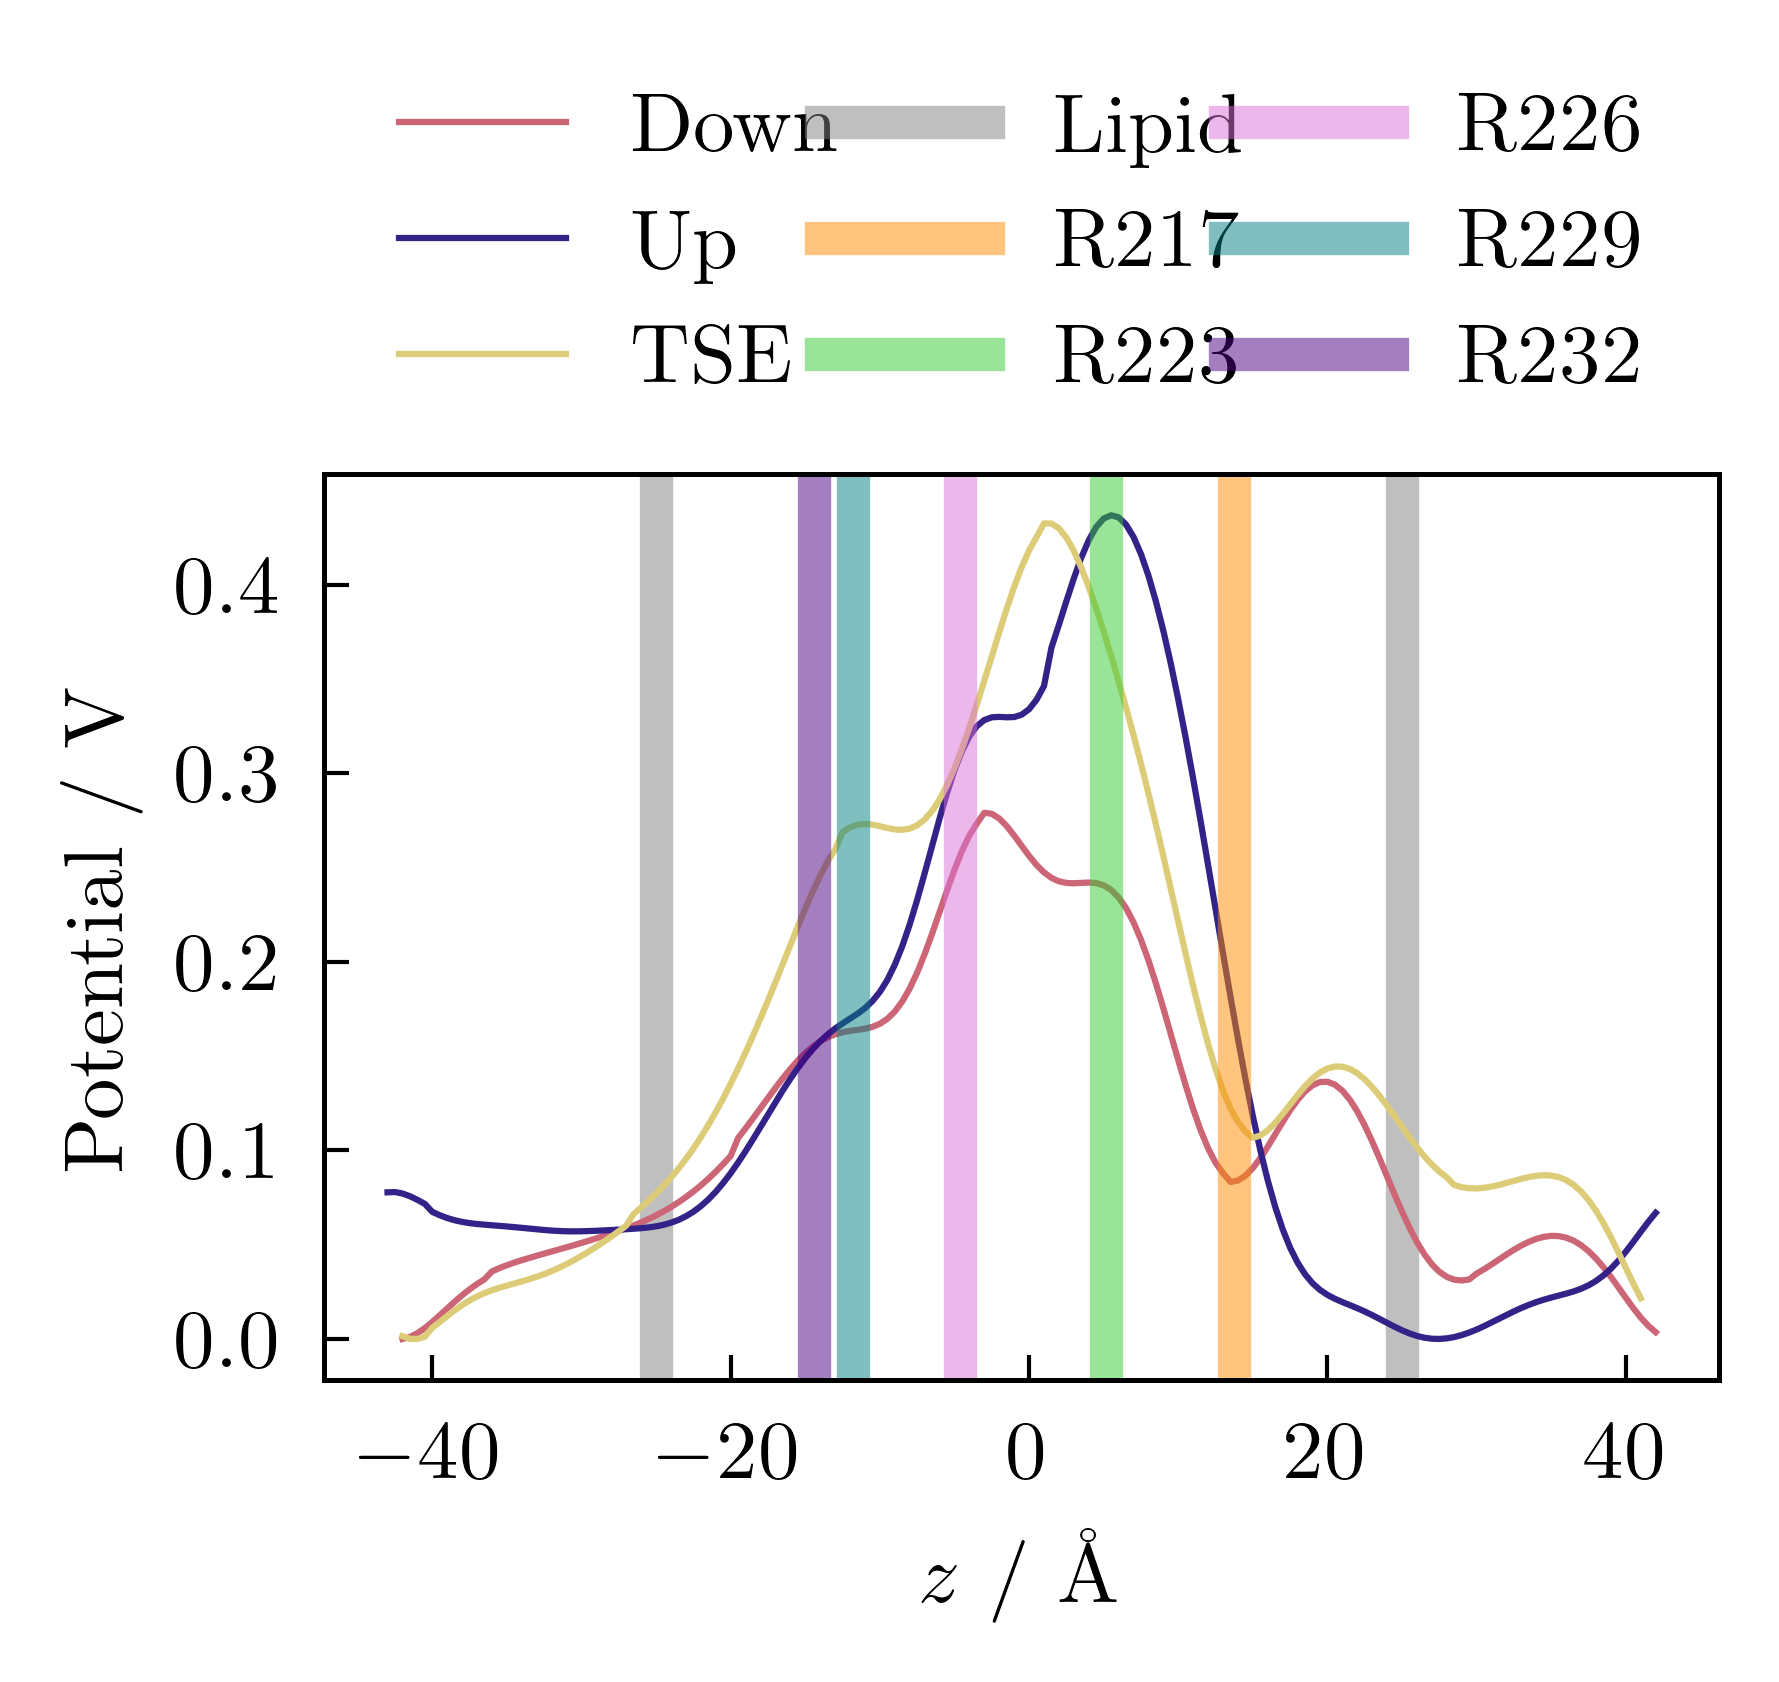

In [183]:
f = plt.figure(figsize=(3, 2), dpi=300)
ax = plt.gca()

labels = ['Down', 'Up', 'TSE']
for a, lab in zip((avg, avg_up, avg_tse), labels):
    a[:, 1] -= np.min(a[:, 1])
    plt.plot(a[:, 0], a[:, 1] * 0.596 / 23.03, label=lab)
plt.xlabel(r"$z$ / $\textrm{\AA}$")
plt.ylabel("Potential / V")
plt.axvline(-25, lw=4, alpha=0.5, zorder=0, color='grey', label='Lipid')
plt.axvline(25, lw=4, alpha=0.5, zorder=0, color='grey')

colors = ['darkorange', 'limegreen', 'orchid', 'teal', 'indigo']
for z, c, r in zip(down_zlocs, colors, (217, 223, 226, 229, 232)):  
    plt.axvline(z, lw=4, alpha=0.5, color=c, label=f"R{r}")
    
pplt.legend(outside='top', ncol=3)

In [ ]:
down_pot = np.loadtxt("../../pmepot/down_pme_frames_aligned-xyz-113.txt")
# down_pot = np.loadtxt("../../pmepot/down_pme_frames-xyz.txt")

In [257]:
y1data = down_pot[:, 0]
z1data = down_pot[:, 1]
edata = down_pot[:, 2]

print(np.min(y1data[np.nonzero(y1data)]))
print(np.max(y1data[np.nonzero(y1data)]))

ylist = y1data.tolist()  # convert a Numpy array to a Python list
num_row = ylist.count(ylist[0])
num_column = len(ylist) // num_row

Ydata = np.reshape(y1data, (num_row, num_column))
Zdata = np.reshape(z1data, (num_row, num_column))
edata = np.reshape(edata, (num_row, num_column))

-90.0
-12.0


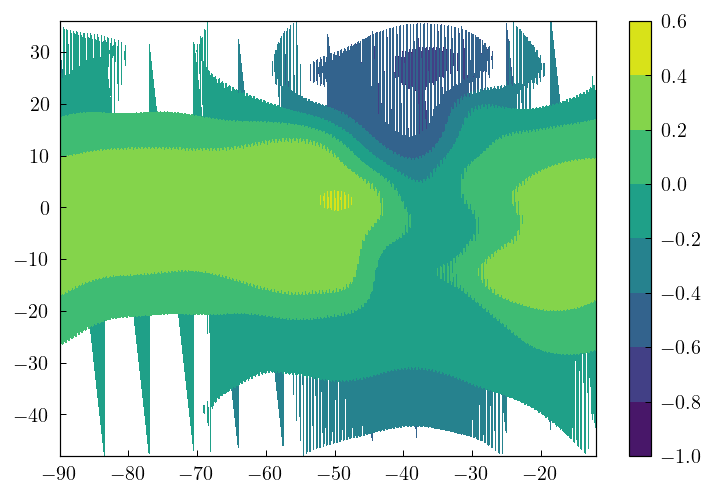

In [258]:
plt.contourf(Ydata, Zdata, edata)
# plt.contourf(Ydata, Zdata, np.gradient(edata)[0])
plt.colorbar()

In [253]:
up_pot = np.loadtxt("../../pmepot/up_pme_frames_aligned-xyz-33.txt")

In [254]:
y1data = up_pot[:, 0]
z1data = up_pot[:, 1]
edata = up_pot[:, 2]

print(np.min(y1data[np.nonzero(y1data)]))
print(np.max(y1data[np.nonzero(y1data)]))

ylist = y1data.tolist()  # convert a Numpy array to a Python list
num_row = ylist.count(ylist[0])
num_column = len(ylist) // num_row

Ydata = np.reshape(y1data, (num_row, num_column))
Zdata = np.reshape(z1data, (num_row, num_column))
edata = np.reshape(edata, (num_row, num_column))

-66.0
11.0


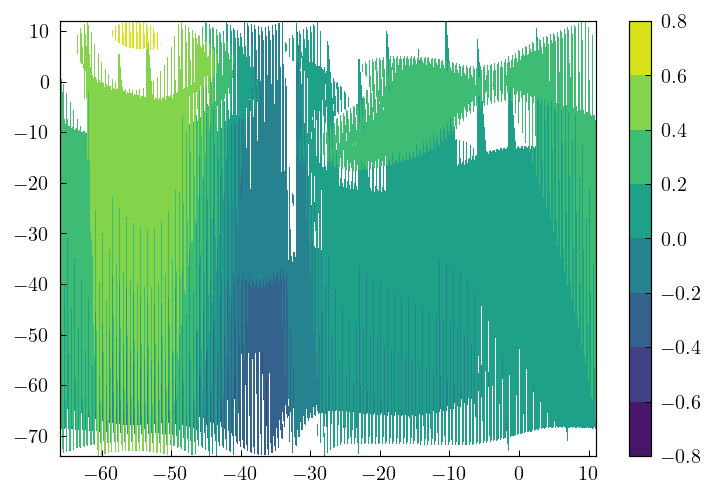

In [255]:
plt.contourf(Ydata, Zdata, edata)
# plt.contourf(Ydata, Zdata, np.gradient(edata)[0])
plt.colorbar()

In [272]:
tse_pot = np.loadtxt("../../pmepot/tse_pme_frames_aligned-xyz-33.txt")

In [273]:
y1data = tse_pot[:, 0]
z1data = tse_pot[:, 1]
edata = tse_pot[:, 2]

print(np.min(y1data[np.nonzero(y1data)]))
print(np.max(y1data[np.nonzero(y1data)]))

ylist = y1data.tolist()  # convert a Numpy array to a Python list
num_row = ylist.count(ylist[0])
num_column = len(ylist) // num_row

Ydata = np.reshape(y1data, (num_row, num_column))
Zdata = np.reshape(z1data, (num_row, num_column))
edata = np.reshape(edata, (num_row, num_column))

-47.0
31.0


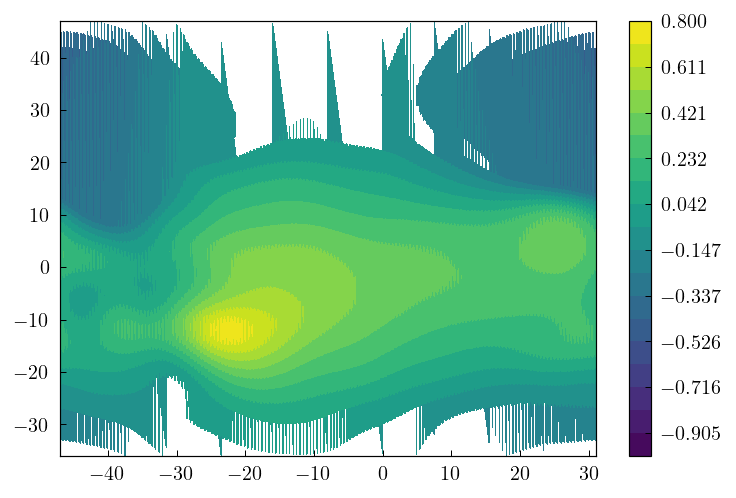

In [275]:
plt.contourf(Ydata, Zdata, edata, levels=np.linspace(-1.0, 0.8, 20))
# plt.contourf(Ydata, Zdata, np.gradient(edata)[0])
plt.colorbar()